In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

In [52]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Define the directory paths
challenge_data_dir = Path('dataset/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [54]:
# get all labels in the dataframes
keys_list = list(split_dataframes.keys())
random.Random(69).shuffle(keys_list) # shuffle, but with a seed for reproducability
split_idx = int(len(keys_list) * 0.8)
train_keys = keys_list[:split_idx]
train_labels_EW = []
train_labels_NS = []
val_keys = keys_list[split_idx:]
val_labels_EW = []
val_labels_NS = []
for key in train_keys:
    train_labels_EW += list(split_dataframes[key]['EW'].unique())
    train_labels_NS += list(split_dataframes[key]['NS'].unique())
for key in val_keys:
    val_labels_EW += list(split_dataframes[key]['EW'].unique())
    val_labels_NS += list(split_dataframes[key]['NS'].unique())
train_labels_EW = list(dict.fromkeys(train_labels_EW))
train_labels_NS = list(dict.fromkeys(train_labels_NS))
val_labels_EW = list(dict.fromkeys(val_labels_EW))
val_labels_NS = list(dict.fromkeys(val_labels_NS))
print(train_labels_EW)
print(val_labels_EW)
print(train_labels_NS)
print(val_labels_NS)


['SS-CK', 'SS-HK', 'SS-EK']
['SS-CK', 'SS-HK']
['SS-NK', 'IK-CK', 'SS-CK', 'SS-HK', 'IK-HK']
['SS-NK', 'IK-CK', 'SS-HK']


In [99]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, train_val_split=0.85, stride=1, input_steps=5, seed=69)

Creating dataset from 15 train and 3 val objects
Created datasets with seed 69


In [169]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=True)
#dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
#dense_model_ns = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
dense_model_ns = prediction_models.Dense_NN(train_NS, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
print("Training model #1")
hist_ew = dense_model_ew.fit(train_EW, val_ds=val_EW, epochs=40, verbose=0, plot_hist=False) # TODO: somehow this sometimes has save_best_only enabled?? even though its only enabled in 2nd fit? ... do inherited models somehow modify the mother class?!?
print("Training model #2")
hist_ns = dense_model_ns.fit(train_NS, val_ds=val_NS, epochs=40, verbose=0, plot_hist=False)
print("EW results:")
dense_model_ew.model.evaluate(train_EW)
dense_model_ew.model.evaluate(val_EW)
print("NS results:")
dense_model_ns.model.evaluate(train_NS)
dense_model_ns.model.evaluate(val_NS)

Training model #1
Training model #2
EW results:
51/51 [==============================] - 0s 3ms/step - loss: 11.8038 - accuracy: 0.5483
NS results:
51/51 [==============================] - 0s 3ms/step - loss: 26.7497 - accuracy: 0.3017


[26.749740600585938, 0.3017188310623169]

(TensorSpec(shape=(None, 5, 16), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 5, 16)]              0         []                            
                                                                                                  
 flatten_31 (Flatten)        (None, 80)                   0         ['input_32[0][0]']            
                                                                                                  
 dense_56 (Dense)            (None, 512)                  41472     ['flatten_31[0][0]']          
                                                                                                  
 dense_57 (Dense)  

c:\Code\ARCLab Challenge\splid-challenge\base\prediction_models.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


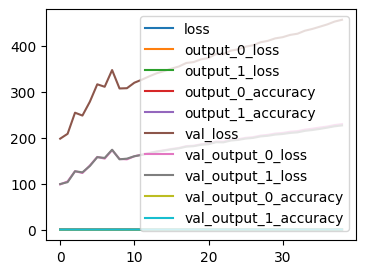

In [195]:
train_combined, val_combined = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=True)
print(train_combined.element_spec)
dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, epochs=40, verbose=2, plot_hist=True)

In [ ]:
# TODO: find out if we can directly train for precision/challenge metrics
# TODO: maybe it makes sense to look at values before and after the node? Given that we are trying to detect changes...
# TODO: check if train_NS even contains all the labels in val_NS... in general, train should contain all labels
# TODO: Make sure labelencoder gets saved
# TODO: Support models with different label features in the submission pipeline

In [259]:
def perform_submission_evaluation(ds_EW, ds_NS, label_encoder, model_ew, model_ns):
    # This approach is dirty, but serves the purpose well
    # inputs and identifiers are identical for both sets
    inputs = np.concatenate([element for element in ds_EW.map(lambda x,y,z: x).as_numpy_iterator()])
    labels_EW = np.concatenate([element for element in ds_EW.map(lambda x,y,z: y).as_numpy_iterator()]).reshape(-1,1) # turn (n,) to (n,1)
    labels_NS = np.concatenate([element for element in ds_NS.map(lambda x,y,z: y).as_numpy_iterator()]).reshape(-1,1)
    identifiers = np.concatenate([element for element in ds_EW.map(lambda x,y,z: z).as_numpy_iterator()])#[:,0,:]
    #print(inputs.shape, labels_EW.shape, labels_NS.shape, identifiers.shape)
    # perform evaluation and prediction
    #model_ew.evaluate(inputs, labels_EW)
    #model_ns.evaluate(inputs, labels_NS)
    preds_ew, preds_ns = model_ew.predict(inputs)
    preds_ew_argmax = np.argmax(preds_ew, axis=1).reshape(-1,1)
    #preds_ns = model_ns.predict(inputs)
    preds_ns_argmax = np.argmax(preds_ns, axis=1).reshape(-1,1)
    # create dataframe that contains all the necessary data
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2), labels_EW, preds_ew_argmax, labels_NS, preds_ns_argmax], axis=1), columns=['ObjectID', 'TimeIndex', 'EW', 'Predicted_EW', 'NS', 'Predicted_NS'], dtype=np.int32)
    # now remove unnecessary columns, decode prediction
    df['Predicted_EW'] = label_encoder.inverse_transform(df['Predicted_EW'])
    df['Predicted_NS'] = label_encoder.inverse_transform(df['Predicted_NS'])
    df['EW'] = label_encoder.inverse_transform(df['EW'])
    df['NS'] = label_encoder.inverse_transform(df['NS'])
    return df

In [254]:
def prepare_submission_df(ds, model, model_output_features, label_decoders):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda *args: args[0]).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda *args: args[-1]).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element for element in ds.map(lambda *args: args[1+ft_idx]).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = preds_decoded
        df[f'Predicted_{feature}'] = labels_decoded
        print(labels[:5])
        print(preds_argmax[:5])
        print(preds_decoded[:5]) # suspicously not different...
    return df


In [252]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])

1019/1019 [==============================] - 2s 2ms/step
   ObjectID  TimeIndex     EW Predicted_EW     NS Predicted_NS
0         1          0  SS-CK        SS-CK  SS-CK        SS-NK
1         1          1  SS-CK        SS-CK  SS-CK        SS-NK
2         1          2  SS-CK        SS-CK  SS-CK        SS-NK
3         1          3  SS-CK        SS-CK  SS-CK        SS-NK
4         1          4  SS-CK        SS-CK  SS-CK        SS-NK


In [256]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

In [257]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_train = utils.smooth_predictions(df_train, past_steps=3, fut_steps=4)
train_results = utils.convert_classifier_output(smoothed_df_train).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')



1019/1019 [==============================] - 2s 2ms/step


Smoothing: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Precision for the train set: 1.00
Recall for the train set: 0.69
F2 for the train set: 0.73
RMSE for the train set: 0.30


In [261]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_val = utils.smooth_predictions(df_val)
val_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_val, val_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the val set: {precision:.2f}')
print(f'Recall for the val set: {recall:.2f}')
print(f'F2 for the val set: {f2:.2f}')
print(f'RMSE for the val set: {rmse:.2f}')


204/204 [==============================] - 0s 2ms/step


Smoothing: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Precision for the val set: 1.00
Recall for the val set: 0.70
F2 for the val set: 0.74
RMSE for the val set: 0.00


In [ ]:
ds_gen_noval = datahandler.DatasetGenerator(split_df=split_dataframes, train_val_split=1.0, stride=1, input_steps=15)
train_EW, train_NS = ds_gen_noval.get_datasets(128, shuffle=True)
dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[128,128], l2_reg=0.0002, mixed_dropout=0.1)
dense_model_ns = prediction_models.Dense_NN(train_EW, dense_layers=[128,128], l2_reg=0.0002, mixed_dropout=0.1)
print("Training model #1")
hist_ew = dense_model_ew.fit(train_EW, epochs=40, verbose=0, plot_hist=False) # TODO: somehow this sometimes has save_best_only enabled?? even though its only enabled in 2nd fit? ... do inherited models somehow modify the mother class?!?
print("Training model #2")
hist_ns = dense_model_ns.fit(train_NS, epochs=40, verbose=0, plot_hist=False)
print("Evaluation:")
eval_res = dense_model_ew.model.evaluate(train_EW)
eval_res = dense_model_ns.model.evaluate(train_NS)

Creating dataset from 18 train and 0 val objects
Created datasets with seed 42
Training model #1
Training model #2
Evaluation:
306/306 [==============================] - 1s 2ms/step - loss: 0.0524 - accuracy: 0.9950


In [ ]:
dense_model_ew.model.save('trained_models/dense_model_ew.h5')
dense_model_ns.model.save('trained_models/dense_model_ns.h5')

c:\Users\David\anaconda3\envs\splid\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('trained_models/dense_model_ew.h5')
new_model.predict(train_EW)
new_model.summary()

306/306 [==============================] - 1s 2ms/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15, 16)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 240)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               30848     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 den

In [ ]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
predictions_final = pd.read_csv('submission/submission.csv')
evaluator = evaluation.NodeDetectionEvaluator(ground_truth, predictions_final)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the val set: {precision:.2f}')
print(f'Recall for the val set: {recall:.2f}')
print(f'F2 for the val set: {f2:.2f}')
print(f'RMSE for the val set: {rmse:.2f}')

Precision for the val set: 0.73
Recall for the val set: 0.65
F2 for the val set: 0.66
RMSE for the val set: 0.46
